<a href="https://colab.research.google.com/github/kabatyy/deepCaptioning/blob/main/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess
import torch
from torchvision import transforms
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

In [2]:
GIT_REPO_URL = "https://github.com/kabatyy/deepCaptioning.git"
COCO_API_REPO = "https://github.com/cocodataset/cocoapi.git"
DIR = "/content/project"
CLONE_DIR = os.path.join(DIR, "deepCaptioning")

def clone_repo():
    os.makedirs(DIR, exist_ok = True)
    os.chdir(DIR)
    if os.path.exists(CLONE_DIR):
        print(f"Repo already exists at {CLONE_DIR}, skipping clone.")
    else:
        subprocess.run(["git", "clone", GIT_REPO_URL], check=True)
        print(f"Repository cloned. Cloning COCO API...")
        os.chdir("/content/project/deepCaptioning")
        subprocess.run(["git", "clone", COCO_API_REPO], check=True)

def process_dataset():
  subprocess.run(["python3", 'start.py'], check=True)
  print("Dataset processing completed.")

def install_cocoapi():
  os.chdir("/content/project/deepCaptioning/cocoapi/PythonAPI")
  subprocess.run(["make"], check=True)
  print("COCO API installation completed.")

In [3]:
print("Cloning repo...")
clone_repo()

Cloning repo...
Repository cloned. Cloning COCO API...


In [4]:
print("Processing dataset...")
process_dataset()

Processing dataset...
Dataset processing completed.


In [5]:
print("Installing COCO API...")
install_cocoapi()
os.chdir("/content/project/deepCaptioning")


Installing COCO API...
COCO API installation completed.


In [6]:
from pycocotools.coco import COCO
from data_loader import get_loader

In [7]:
dataDir ="/content/project/deepCaptioning/cocoapi/annotations"
datatype='val2024'
instances_annFile = os.path.join(dataDir, 'instances_train2014.json'.format(datatype))
coco = COCO(instances_annFile)

captions_annFile = os.path.join(dataDir, 'captions_train2014.json'.format(datatype))
coco_caps = COCO(captions_annFile)

ids= list(coco.anns.keys())


loading annotations into memory...
Done (t=15.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


http://images.cocodataset.org/train2014/COCO_train2014_000000355918.jpg


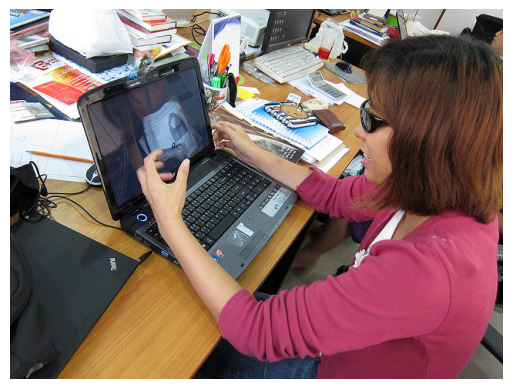

Female appears to be upset with something having to do with her computer.
A young woman sits in front of a notebook computer.
A woman wearing sunglasses sitting at a desk looking at her laptop
a lady that is in front of her lap top
Woman sitting at desk using electronic equipment indoors.


In [8]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [9]:
# Watch for any changes in vocabulary.py, data_loader.py or model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

In [10]:

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
#preprocess the training data
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])
vocab_threshold = 5
batch_size = 16

data_loader = get_loader(transform=transform_train,
                         mode ='train',
                         batch_size = batch_size,
                         vocab_threshold = vocab_threshold,
                         vocab_from_file = False)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:41<00:00, 9979.72it/s] 


In [12]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

In [13]:
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())

In [14]:
sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

Special start word: <start>
[0]


In [15]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18]


In [16]:
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18, 1]


In [17]:
sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([   0,    3,   98,  754,    3,  396,   39,    3, 1010,  207,  139,    3,
         753,   18,    1])


 any caption is converted to a list of tokens, with _special_ start and end tokens marking the beginning and end of the sentence:
```
[<start>, 'a', 'person', 'doing', 'a', 'trick', 'while', 'riding', 'a', 'skateboard', '.', <end>]
```
This list of tokens is then turned into a list of integers, where every distinct word in the vocabulary has an associated integer value:
```
[0, 3, 98, 754, 3, 396, 207, 139, 3, 753, 18, 1]
```
Finally, this list is converted to a PyTorch tensor.

In [18]:
# Preview the word2idx dictionary.
print (dict(list(data_loader.dataset.vocab.word2idx.items())[:10]))

# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

{'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 8852


In [19]:
vocab_threshold = 5

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:42<00:00, 9725.04it/s] 


Total number of tokens in vocabulary: 8852


All tokens that don't appear anywhere in the `word2idx` dictionary are considered unknown words.  In the pre-processing step, any unknown tokens are mapped to the integer `2`.

In [20]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))
print ("For example:")
print("'jfkafejw' is mapped to", data_loader.dataset.vocab('jfkafejw'))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2
For example:
'jfkafejw' is mapped to 2


Building the vocabulary from scratch is the most time-consuming part of instantiating the data loader, and so we are strongly encouraged to set `vocab_from_file=True` as soon as we are able.


In [21]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from file!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:44<00:00, 9323.93it/s]
